<a href="https://colab.research.google.com/github/rjvmhn007/Rain-Prediction/blob/master/Rain_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
full_data = pd.read_csv('/content/drive/MyDrive/weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# checking the data size
full_data.shape

(145460, 23)

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
#“RainToday” and “RainTomorrow” are objects (Yes / No).  convert them to binary (1/0) for our convenience.

full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

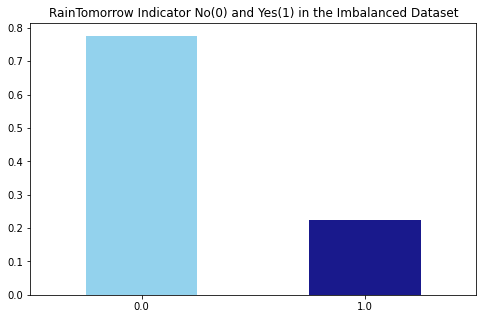

In [7]:
#we will check if the dataset is unbalanced or balanced. 
#If the data set is unbalanced, we need to either downsample the majority or oversample the minority to balance it

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In [8]:
#observe that the presence of “0” and “1” is almost in the 78:22 ratio. 
#So there is a class imbalance and we have to deal with it
#To fight against the class imbalance, we will use here the oversampling of the minority class
#Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here

Handling Class Imbalance For Rainfall Prediction

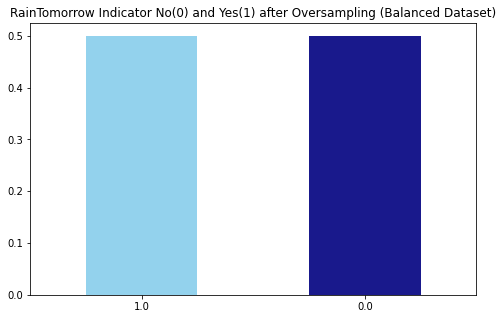

In [9]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

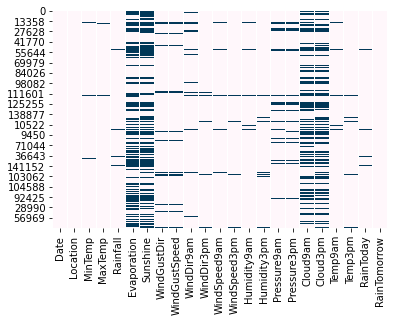

In [10]:
## check the missing data model in the dataset:
# checking which has maximum number of null values 

import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [11]:
# Above figure  Evaporation, sunshine, cloud9am, cloud3pm has maximum null values

#check the details of the missing data for these 4 features.

total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [12]:
# features have less than 50 per cent missing data. 
# So instead of rejecting them completely, we’ll consider them in our model with proper imputation

Imputation and Transformation

In [13]:
# Will impute the categorical columns with mode, and then will use the label encoder to convert them to numeric numbers
# All the columns in the full data frame are converted to numeric columns
# We will impute the missing values using the Multiple Imputation by Chained Equations (MICE) package.
# Then will detect outliers using the interquartile range and remove them to get the final working dataset.
# will check the correlation between the different variables
# if we find a pair of highly correlated variables, we will discard one while keeping the other

oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [14]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [15]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [16]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [17]:
#the dataframe has no “NaN” value. 
# We will now detect and eliminate outliers from the inter-quartile interval-based data set

# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [18]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

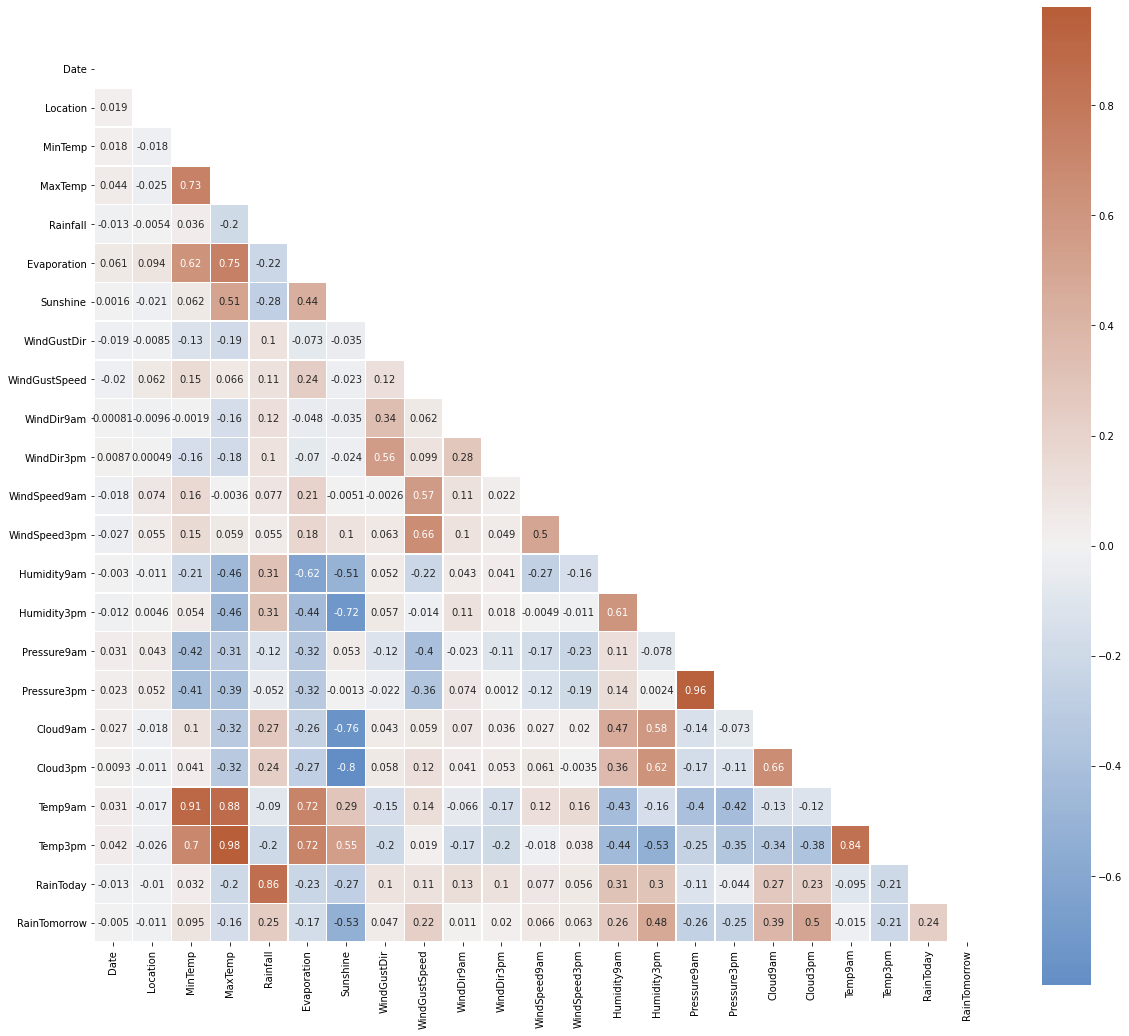

In [19]:
# going to check multicollinearity, that is to say if a character is strongly correlated with another.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})


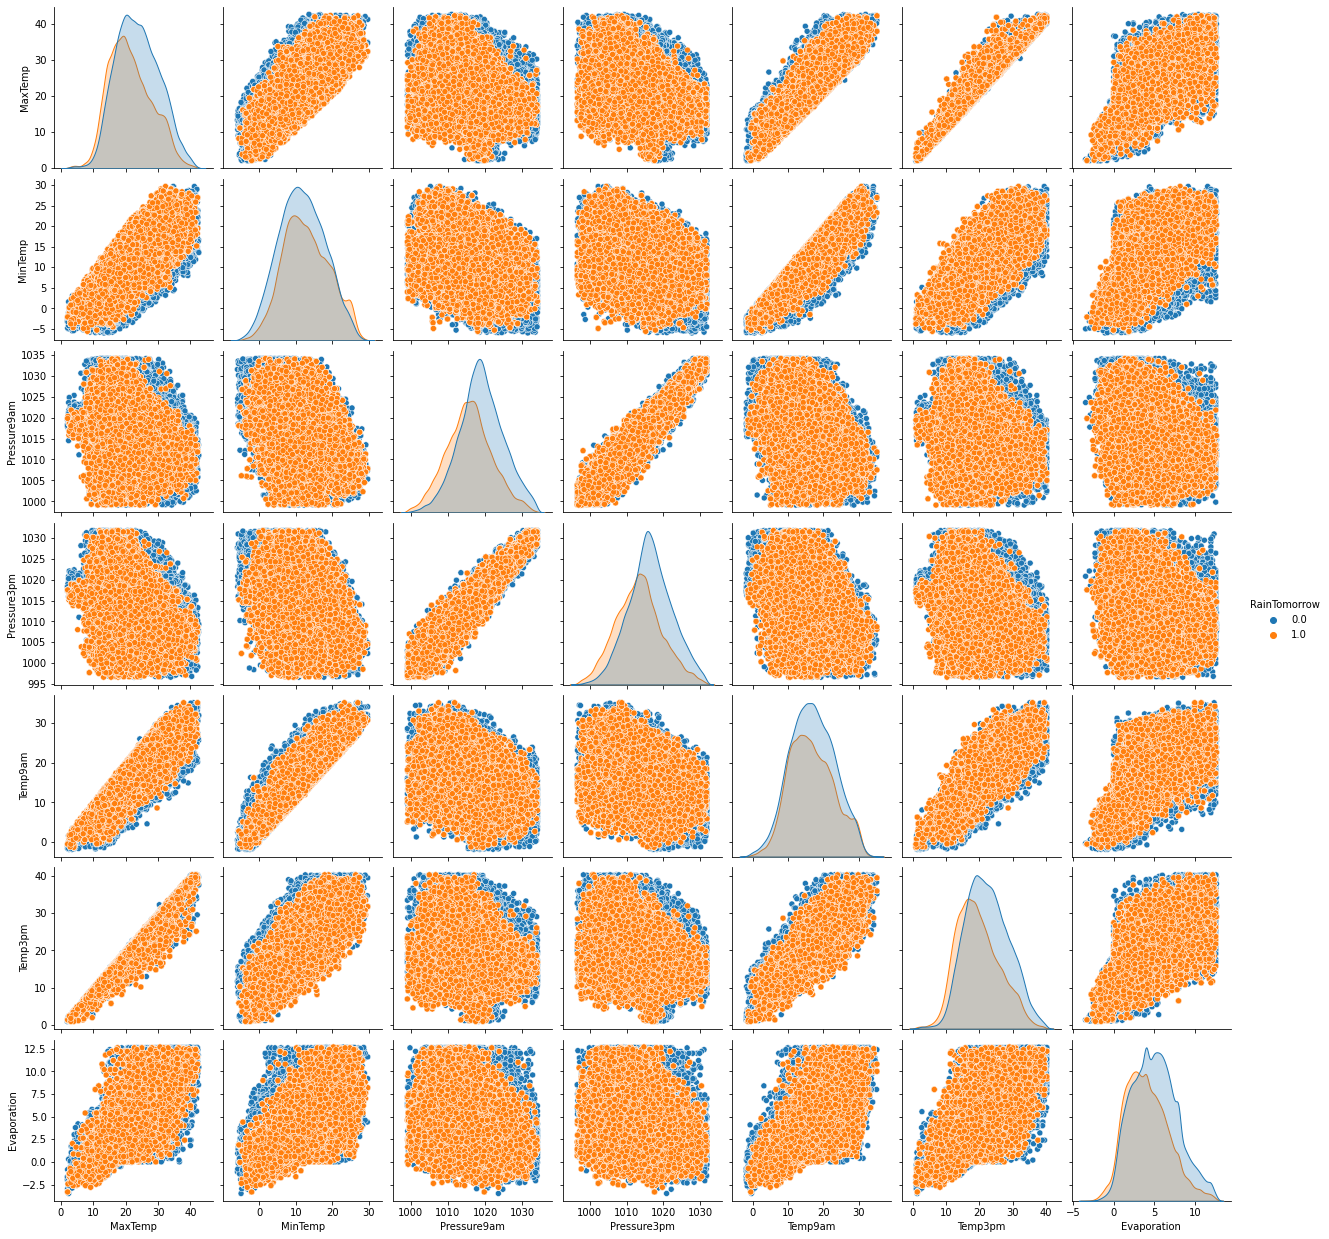

In [20]:
#no case is the correlation value equal to a perfect “1”. therefore not removing any functionality

# However,can delve deeper into the pairwise correlation between these highly correlated characteristics by examining the following pair diagram. 
# Each of the paired plots shows very clearly distinct clusters of RainTomorrow’s “yes” and “no” clusters. 
# There is very minimal overlap between them.

sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )


Feature Selection for Rainfall Prediction

In [21]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [22]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [23]:
## Selection of features by wrapping method (random forest):

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


Training Rainfall Prediction Model with Different Models

In [25]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [26]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [27]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7952798350051561
ROC Area under Curve = 0.7895421146723749
Cohen's Kappa = 0.5823246558119864
Time taken = 3.6979358196258545
              precision    recall  f1-score   support

         0.0    0.80459   0.83764   0.82078     23879
         1.0    0.78229   0.74144   0.76132     18789

    accuracy                        0.79528     42668
   macro avg    0.79344   0.78954   0.79105     42668
weighted avg    0.79477   0.79528   0.79460     42668



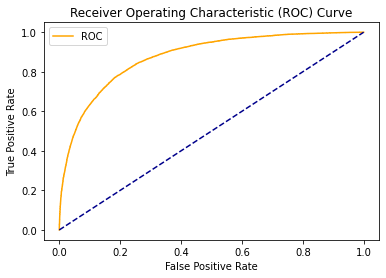

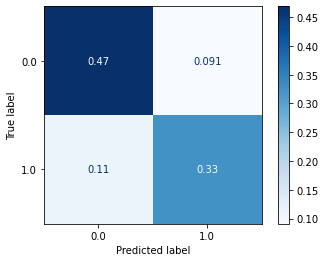

In [28]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)



Accuracy = 0.8554654542045561
ROC Area under Curve = 0.8559456784680777
Cohen's Kappa = 0.7082555022204391
Time taken = 0.5817203521728516
              precision    recall  f1-score   support

         0.0    0.88548   0.85192   0.86838     23879
         1.0    0.82045   0.85997   0.83975     18789

    accuracy                        0.85547     42668
   macro avg    0.85297   0.85595   0.85406     42668
weighted avg    0.85684   0.85547   0.85577     42668



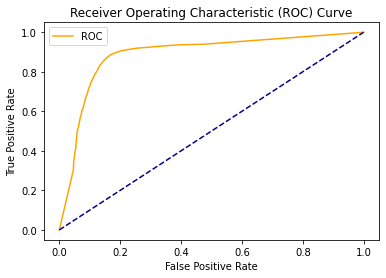

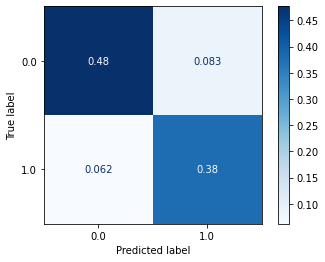

In [29]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)


Accuracy = 0.8831677135089528
ROC Area under Curve = 0.8825219761888251
Cohen's Kappa = 0.7634546107033483
Time taken = 396.54026341438293
              precision    recall  f1-score   support

         0.0    0.90179   0.88794   0.89481     23879
         1.0    0.86030   0.87711   0.86863     18789

    accuracy                        0.88317     42668
   macro avg    0.88105   0.88252   0.88172     42668
weighted avg    0.88352   0.88317   0.88328     42668



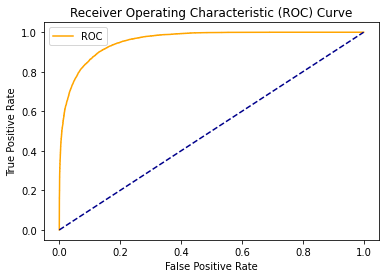

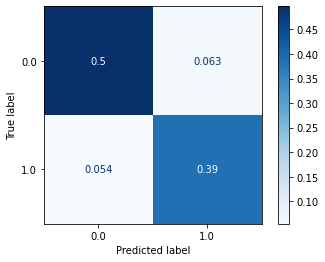

In [30]:
# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)


Accuracy = 0.9265960438736289
ROC Area under Curve = 0.9279584837896794
Cohen's Kappa = 0.8517906871231153
Time taken = 35.71535015106201
              precision    recall  f1-score   support

         0.0    0.95053   0.91654   0.93323     23879
         1.0    0.89854   0.93938   0.91851     18789

    accuracy                        0.92660     42668
   macro avg    0.92454   0.92796   0.92587     42668
weighted avg    0.92764   0.92660   0.92674     42668



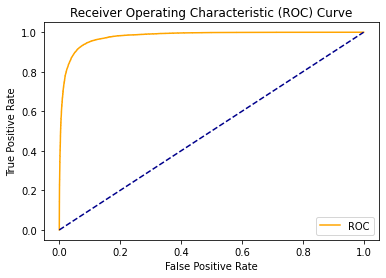

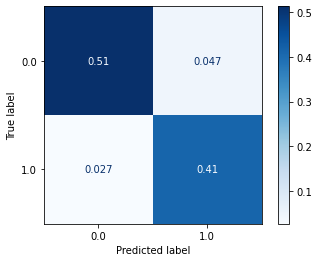

In [31]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

Accuracy = 0.864722977406956
ROC Area under Curve = 0.8615448366915223
Cohen's Kappa = 0.724865945212627
Time taken = 6.711463928222656
              precision    recall  f1-score   support

         0.0    0.87240   0.88819   0.88022     23879
         1.0    0.85455   0.83490   0.84461     18789

    accuracy                        0.86472     42668
   macro avg    0.86348   0.86154   0.86242     42668
weighted avg    0.86454   0.86472   0.86454     42668



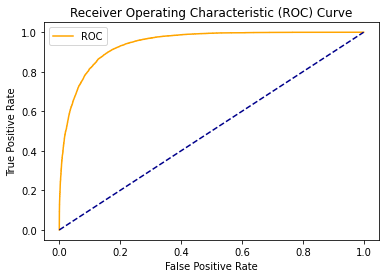

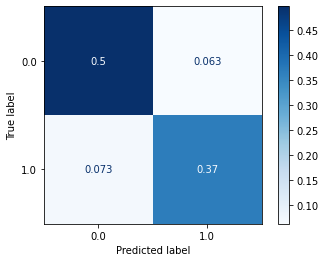

In [32]:
# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

     |████████████████████████████████| 65.7MB 67kB/s 
Accuracy = 0.9392050248429736
ROC Area under Curve = 0.9424115092864753
Cohen's Kappa = 0.8776540964755455
Time taken = 261.8215379714966
              precision    recall  f1-score   support

         0.0    0.97429   0.91553   0.94400     23879
         1.0    0.90029   0.96929   0.93352     18789

    accuracy                        0.93921     42668
   macro avg    0.93729   0.94241   0.93876     42668
weighted avg    0.94170   0.93921   0.93938     42668



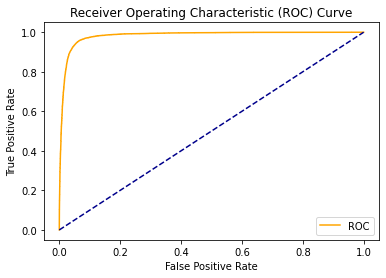

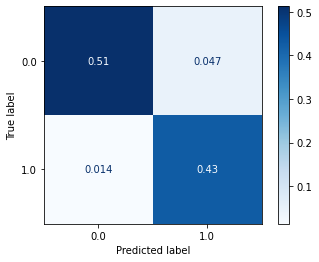

In [34]:
# Catboost
!pip install catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)



Accuracy = 0.949118777538202
ROC Area under Curve = 0.9514785434578668
Cohen's Kappa = 0.8974034120383265
Time taken = 439.4911103248596
              precision    recall  f1-score   support

         0.0    0.97630   0.93170   0.95348     23879
         1.0    0.91796   0.97126   0.94386     18789

    accuracy                        0.94912     42668
   macro avg    0.94713   0.95148   0.94867     42668
weighted avg    0.95061   0.94912   0.94924     42668



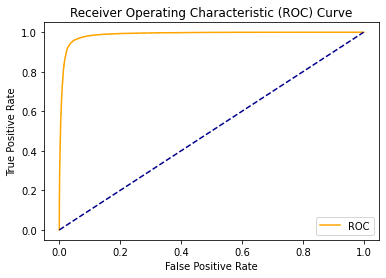

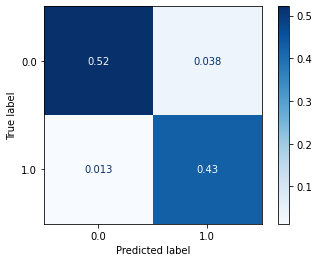

In [35]:
# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)


Plotting Decision Region for all Models

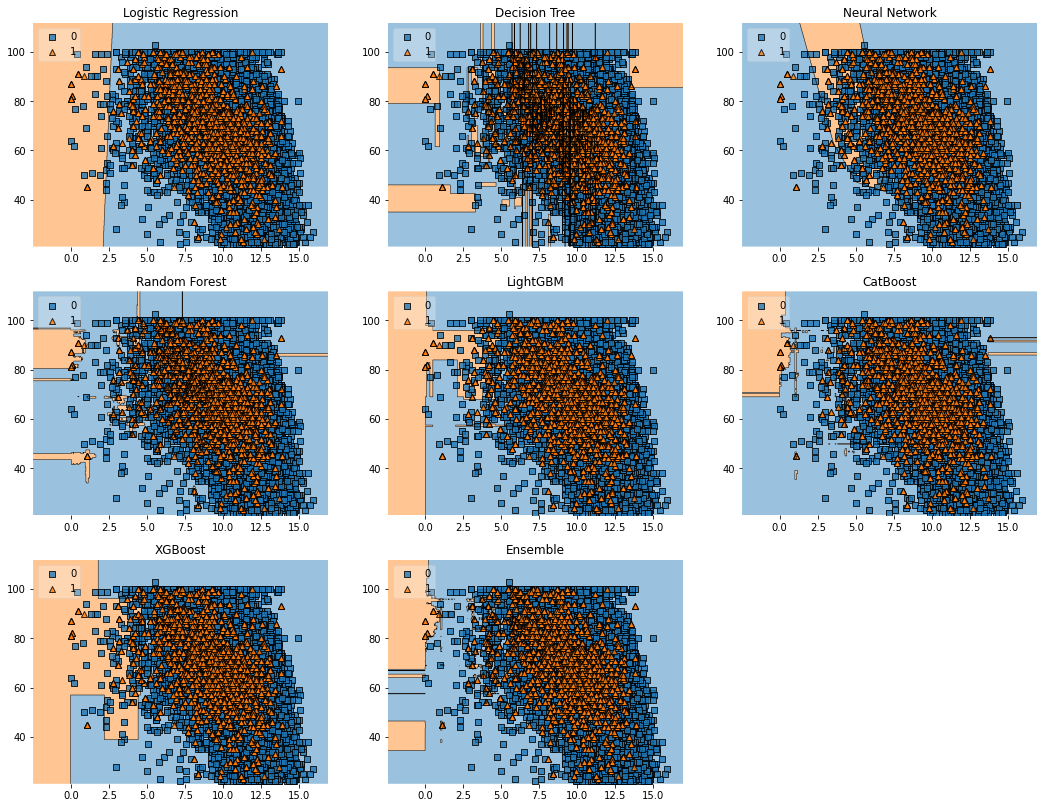

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

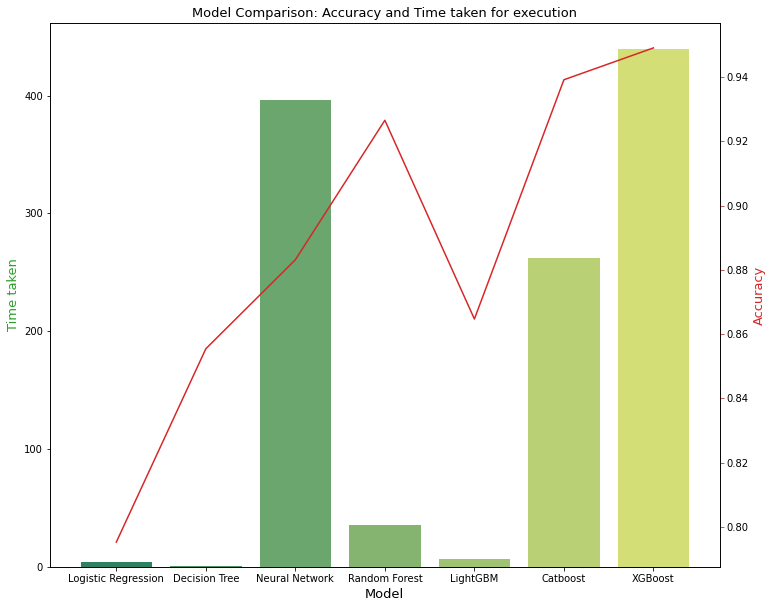

In [37]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

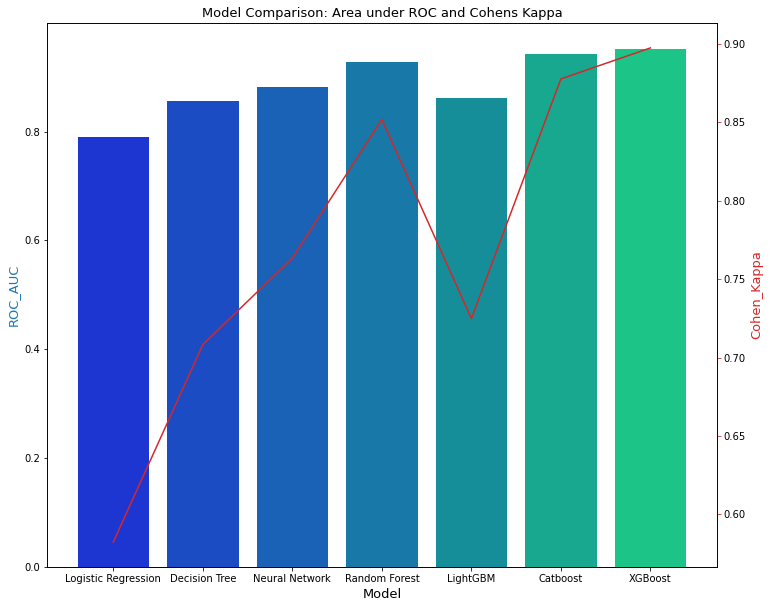

In [38]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()